# Assignment 1
## Multiclass Support Vector Machine

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [3]:
# 加载 cifar-10 数据集
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


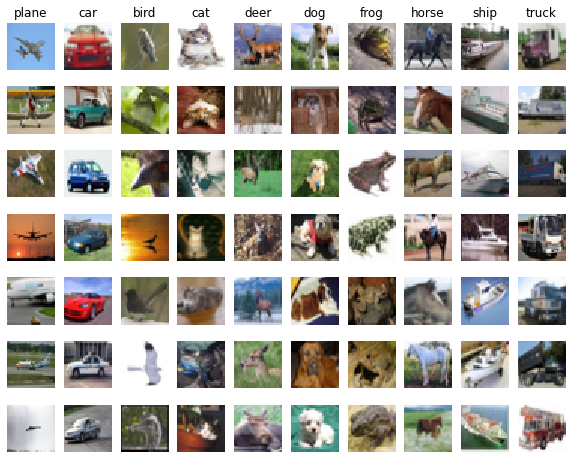

In [4]:
# 从每个类选出一些训练图片用来显示
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# 划分训练集、验证集和测试集
# 我们还另外划分了一个很小的开发集，作为训练数据的一个子集
# 我们使用开发集开发，可以安加速代码的运行
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 验证集
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 训练集
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 开发集
mask = np.random.choice(num_training, num_dev, replace = False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 测试集
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# 将图片数据压成行
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


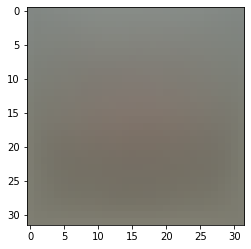

In [7]:
# 减去均值图像
# step1. 计算通过训练数据计算图像的均值
mean_image = np.mean(X_train, axis = 0)
print(mean_image[:10])
plt.figure(figsize = (4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))
plt.show()

In [8]:
# step2. 从训练集合测试集中减去均值图像
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# step3. 附加 1 的偏差维度，这样我们的 SVM 就只需要优化一个权重矩阵 W
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.zeros((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.zeros((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.zeros((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [10]:
# SVM Classifier
# 实现一个简单版本的损失函数
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# 随机产生一个小数值的初始化权重矩阵
W = np.random.randn(3073, 10) * 0.0001

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
print('loss: %f' % (loss,))

loss: 9.663784


In [11]:
# 为了验证我们正确实现了梯度的计算
# 我们可以对损失函数的梯度进行数值估计
# 并将数值估计值与上面得到的梯度进行比较
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# 随机选取一些维度计算数值梯度，然后与上面得到的梯度进行比较
# 这些数值应该在所有维度上都是匹配的
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 再进行一次梯度检查，这次带上正则化
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.00001)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.00001)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.656279 analytic: 1.656279, relative error: 3.411672e-11
numerical: -39.422691 analytic: -39.422691, relative error: 1.133501e-11
numerical: 7.818665 analytic: 7.818665, relative error: 9.680583e-12
numerical: 5.079595 analytic: 5.079595, relative error: 8.834303e-11
numerical: 10.631348 analytic: 10.631348, relative error: 8.835628e-12
numerical: -4.732535 analytic: -4.732535, relative error: 1.236041e-10
numerical: 6.477378 analytic: 6.477378, relative error: 1.362754e-11
numerical: 8.593557 analytic: 8.593557, relative error: 3.154333e-11
numerical: -1.963502 analytic: -1.963502, relative error: 2.269207e-11
numerical: 14.558373 analytic: 14.558373, relative error: 1.560849e-11
numerical: -15.899933 analytic: -15.899933, relative error: 4.235232e-12
numerical: -12.397505 analytic: -12.397505, relative error: 2.713788e-13
numerical: 21.283427 analytic: 21.283427, relative error: 9.306511e-12
numerical: -3.801903 analytic: -3.801903, relative error: 1.021583e-11
numerical:


梯度检查中的维度有时可能不匹配。造成这种差异的原因是什么？这是一个值得关注的原因吗？某一维度梯度检查失败的简单示例是什么？提示：严格来说，SVM 的损失函数是不可微的

答：

损失函数在某些点的不可导情况将导致这种差异。例如，对于 ReLU，$f(x)=max(0,x)$ 在 $x=0$ 处即不可导。数值梯度的公式为 $\frac{df(x)}{dx}=\frac{f(x+h)-f(x-h)}{2h}$。显然，在 $x=0$ 附近会出现数值梯度和分析梯度存在差异的情况

In [12]:
# 实现向量化的 SVM 损失函数
# 我们现在值计算损失时，稍后在处理梯度
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss: %e computes in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 两种方法的损失应该是一样的，但是向量化应该更快一些
print('Difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.663784e+00 computes in 0.063026s
Vectorized loss: 9.663784e+00 computed in 0.000000s
Difference: 0.000000


In [13]:
# 计算向量化的 SVM 损失，同时也以向量化的方式计算损失的梯度

tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc- tic))

# 损失值计算出来仅仅是一个数值，很容易比较两种方式得到的损失值的差异
# 而梯度则是一个矩阵，我们还是采用 F-范数计算差异
difference = np.linalg.norm(grad_naive - grad_vectorized, ord = 'fro')
print('Difference of gradient matrix: %f' % difference)

Naive loss and gradient: computed in 0.078017s
Vectorized loss and gradient: computed in 0.005004s
Difference of gradient matrix: 0.000000


## 随机梯度下降(SGD)


In [19]:
# linear_classifier.py 中，我们在 LinearClassifier.train() 中实现了 SGD
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate = 1e-7, reg = 5e4, num_iters = 1500, verbose = True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.318526
iteration 100 / 1500: loss 288.150324
iteration 200 / 1500: loss 108.348022
iteration 300 / 1500: loss 42.626894
iteration 400 / 1500: loss 19.107844
iteration 500 / 1500: loss 10.145108
iteration 600 / 1500: loss 6.630659
iteration 700 / 1500: loss 6.365066
iteration 800 / 1500: loss 5.456419
iteration 900 / 1500: loss 5.357317
iteration 1000 / 1500: loss 5.346059
iteration 1100 / 1500: loss 5.270205
iteration 1200 / 1500: loss 4.971808
iteration 1300 / 1500: loss 5.608639
iteration 1400 / 1500: loss 5.903318
That took 5.921339s


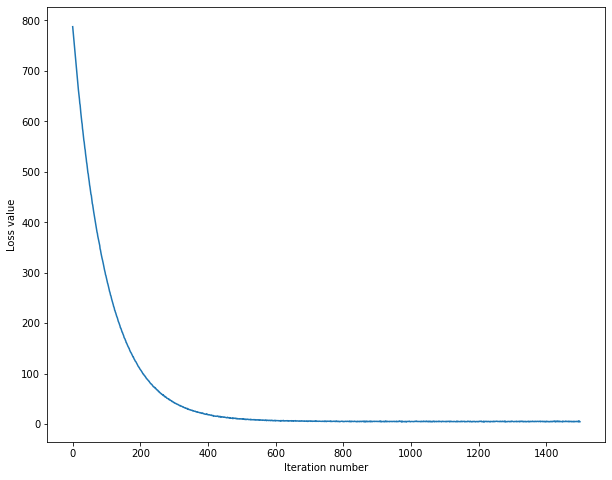

In [20]:
# 绘制损失函数随迭代次数变化的图像
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# 使用 LinearSVM.predict 函数进行预测
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.371714
validation accuracy: 0.378000


In [26]:
# 使用验证集调优
learning_rates = [1.4e-7, 1.5e-7, 1.6e-7]
regularization_strengths = [(1 + i * 0.1) * 1e4 for i in range(-3, 3)] + [(2 + 0.1 * i) * 1e4 for i in range(-3, 3)]

# 结果应该得到一个映射字典 (learning_rate, regularization_strength) -> (training_accuracy validation_accuracy)
results = {}
best_val = -1
best_svm = None

# 对于每一种超参数的组合，我们都在训练集上训练一个线性的 SVM
# 提示：我们应该将 num_iters 设定为一个较小值，这样在设置不同超参数组合训练 SVM 时不会花费过多的时间
# 一旦我们确定调优的代码可以运行时，我们则应该将 num_iters 设定为一个比较大的值

for rs in regularization_strengths:
    for lr in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, lr, rs, num_iters = 3000)
        y_train_pred = svm.predict(X_train)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm
        results[(lr, rs)] = training_accuracy, val_accuracy

for lr, reg in sorted(results):
    training_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy %f' % (lr, reg, training_accuracy, val_accuracy))

print('best validation accuracy achieved durign cross-validation: %f' % best_val)

lr 1.400000e-07 reg 7.000000e+03 train accuracy: 0.399245 val accuracy 0.401000
lr 1.400000e-07 reg 8.000000e+03 train accuracy: 0.395490 val accuracy 0.393000
lr 1.400000e-07 reg 9.000000e+03 train accuracy: 0.392000 val accuracy 0.400000
lr 1.400000e-07 reg 1.000000e+04 train accuracy: 0.390571 val accuracy 0.394000
lr 1.400000e-07 reg 1.100000e+04 train accuracy: 0.391857 val accuracy 0.404000
lr 1.400000e-07 reg 1.200000e+04 train accuracy: 0.385694 val accuracy 0.397000
lr 1.400000e-07 reg 1.700000e+04 train accuracy: 0.385510 val accuracy 0.384000
lr 1.400000e-07 reg 1.800000e+04 train accuracy: 0.384898 val accuracy 0.379000
lr 1.400000e-07 reg 1.900000e+04 train accuracy: 0.386082 val accuracy 0.386000
lr 1.400000e-07 reg 2.000000e+04 train accuracy: 0.380959 val accuracy 0.374000
lr 1.400000e-07 reg 2.100000e+04 train accuracy: 0.373816 val accuracy 0.386000
lr 1.400000e-07 reg 2.200000e+04 train accuracy: 0.382041 val accuracy 0.386000
lr 1.500000e-07 reg 7.000000e+03 train a

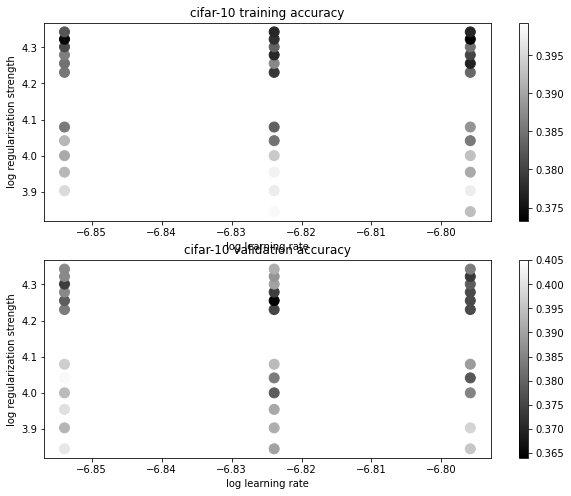

In [29]:
# 可视化交叉验证的结果
import math 
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c = colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('cifar-10 training accuracy')

colors = [results[x][1] for x in results]
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c = colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('cifar-10 validation accuracy')
plt.show()

In [31]:
# 在测试集上验证最好的 svm
y_tets_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_tets_pred)
print('linear Svm on raw pixels final test set accuracy: %f' % test_accuracy)

linear Svm on raw pixels final test set accuracy: 0.378000


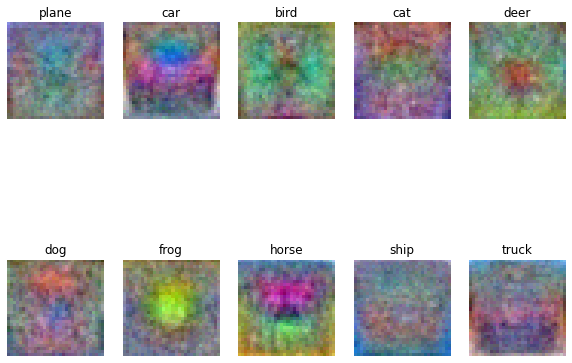

In [36]:
# 可视化每个类学习到的权重
w = best_svm.W[:-1,:] # 把偏差分割出去
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # 将权重值调整到 0-255 内
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])